In [1]:
#Importing necesary data pacakages
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy import ndimage as nd
from skimage import io
import time
import cv2
from scipy.fft import fft, ifft
from numpy.fft import fft, fftfreq, ifft
from scipy import fftpack
from PIL import Image, ImageDraw

1. Load an image

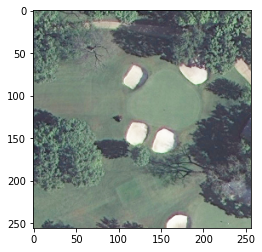

In [2]:
img = io.imread('golfcourse02.tif')
plt.imshow(img)

2. Verify the invertibility of the FFT: $I = IF F T (F F T (I))$

/tmp/ipykernel_141/284662610.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.subplot(132),plt.imshow((fft_imgage).astype(np.uint8))
/tmp/ipykernel_141/284662610.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.subplot(133),plt.imshow((ifft_imgage).astype(np.uint8))


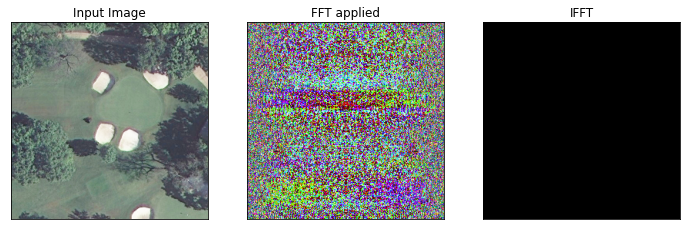

In [3]:
# Do a Fourier transform on the signal
fft_imgage  = np.fft.fft2(img)

# shift FFT to the center
fft_img_shift = np.fft.fftshift(fft_imgage)
magnitude_spectrum =0.1*np.log(np.abs(fft_img_shift))

# Do an inverse Fourier transform on the signal
ifft_imgage = np.fft.ifft(magnitude_spectrum)

#plotting
plt.figure(figsize =(12,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Input Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow((fft_imgage).astype(np.uint8))
plt.title('FFT applied'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow((ifft_imgage).astype(np.uint8))
plt.title('IFFT'), plt.xticks([]), plt.yticks([])
plt.show()

When applying simple available functions I encountered the above issue. I am not sure if this method works but I assume that I am not able to see any due not taking into consideration the complex nature of signal that includes both real and imaginary information as shown in the warning. We can't do reverse with just the magnitudes as the phase information is lost so phase also should be preserved.

Also the use of fftshift was for useful for visualizing a Fourier transform with the zero-frequency component in the middle of the spectrum. The shift is not necessary to perform the fft, but it is handy to visualise the Fourier transform.


In [4]:
# do the 2D fourier transform
fft_img = np.fft.fft2(img)

# shift FFT to the center
fft_img_shift = np.fft.fftshift(fft_img)
magnitude_spectrum =0.1*np.log(np.abs(fft_img_shift))

In [5]:
# extract real and phases
real = fft_img_shift.real
phases = fft_img_shift.imag

# modify real part, put your modification here
real_mod = real/3

# create an empty complex array with the shape of the input image
fft_img_shift_mod = np.empty(real.shape, dtype=complex)

# insert real and phases to the new file
fft_img_shift_mod.real = real_mod
fft_img_shift_mod.imag = phases

# reverse shift
fft_img_mod = np.fft.ifftshift(fft_img_shift_mod)

# reverse the 2D fourier transform
img_mod = np.fft.ifft2(fft_img_mod)
np.seterr(divide = 'ignore')
magnitude_reverse =0.12*np.log(np.abs(img_mod))


In the above script I used numpy.sterr to turn warnings off, as I was encountering a runtime warning saying, "RuntimeWarning: divide by zero encountered in log".

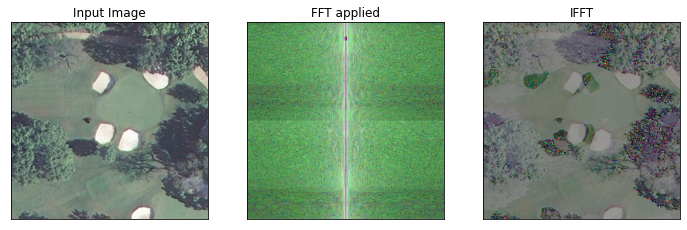

In [6]:
#plotting
plt.figure(figsize =(12,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Input Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow((magnitude_spectrum* 255).astype(np.uint8))
plt.title('FFT applied'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow((magnitude_reverse* 255).astype(np.uint8))
plt.title('IFFT'), plt.xticks([]), plt.yticks([])
plt.show()

The image obtained from Inverse Fourier Transform was similar to the one fed in but differ a little in intensity. This implies that I successfully preserved my phase information but magnitude was not well preserved. Still I will say **Verrified that** $I = IF F T (F F T (I))$ as satisfactory result was achieved.

3. Compare the effect of the main low-pass (w.r.t $D_0$) and show the FFT before and after filtering.

A low-pass filter is just a gray-scale image, whose values are higher near the center, and close to zero outside. We then multiply this gray-scale image to the Fourier Transform of the original image. What we get is another frequency-domain image, whose values outer side are squashed to zero. This means that higher frequency components are removed, and lower frequency components remain unchanged.

In simple words, a low-pass filter is a technique used in computer vision to get a blurred image, or to store an image with less space.

In [7]:
#gray-scale image
imgGray = color.rgb2gray(img)

# fft of image through different method than previous using fftpack
fft1 = fftpack.fftshift(fftpack.fft2(imgGray))
magnitude1 =0.1*np.log(np.abs(fft1))

#Create a low pass filter image 

x,y = imgGray.shape[0],imgGray.shape[1]
#size of circle
e_x,e_y=50,50
#create a box 
bbox=((x/2)-(e_x/2),(y/2)-(e_y/2),(x/2)+(e_x/2),(y/2)+(e_y/2))
low_pass=Image.new("L",(imgGray.shape[0],imgGray.shape[1]),color=0)
draw1=ImageDraw.Draw(low_pass)
draw1.ellipse(bbox, fill=1)
low_pass_np=np.array(low_pass)



#multiply the fourier transformed signal with the low pass filter
filtered=np.multiply(fft1,low_pass_np)

#inverse fft
ifft2 = np.real(fftpack.ifft2(fftpack.ifftshift(filtered)))
ifft2 = np.maximum(0, np.minimum(ifft2, 255))


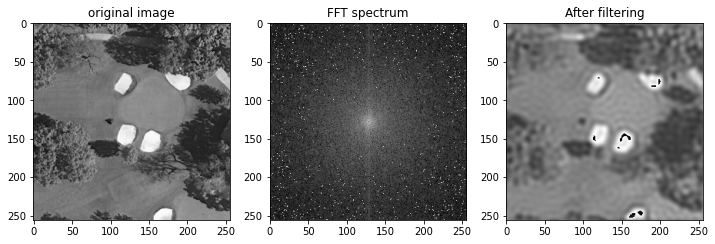

In [24]:
#plotting

plt.figure(figsize=(12,10))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title('original image')
plt.subplot(132)
plt.title('FFT spectrum')
plt.imshow((magnitude1* 255).astype(np.uint8), cmap = 'gray')
plt.subplot(133)
plt.imshow((ifft2* 255).astype(np.uint8), cmap = 'gray')
plt.title('After filtering')
plt.show()

We can see that the filtered one is blurred. This is because higher frequency components (details) are removed and only lower frequency components (rough shape) remain unchanged.

4. Compare the effect of the main high-pass (w.r.t $D_0$) and show the FFT before and after filtering.

In [11]:
#frequency spectrum generation
F1 = fftpack.fft2((imgGray).astype(float))
F2 = fftpack.fftshift(F1)

#width and height of image
(w, h) = imgGray.shape
half_w, half_h = int(w/2), int(h/2)

# high pass filter
n = 15 #change in this changes the raidus in my final outcome
F2[half_w-n:half_w+n+1,half_h-n:half_h+n+1] = 0 # filling my center values with 0

#inverse fft
ifft3 = np.real(fftpack.ifft2(fftpack.ifftshift(F2)))
ifft3 = np.maximum(0, np.minimum(ifft3, 255))

/tmp/ipykernel_141/2573843854.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow( (20*np.log( 0.1 + F2)).astype(int),cmap='gray')


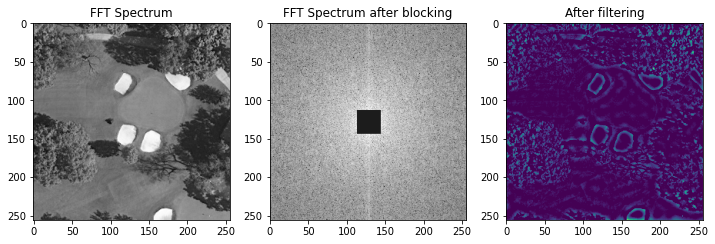

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title('FFT Spectrum')
plt.subplot(132)
plt.imshow( (20*np.log( 0.1 + F2)).astype(int),cmap='gray')
plt.title('FFT Spectrum after blocking')
plt.subplot(133)
plt.imshow(ifft3)
plt.title('After filtering')
plt.show()

5. Perform image sharpening in the frequency domain

Frequency Domain Filters are used for smoothing and sharpening of image by removal of high or low frequency components.

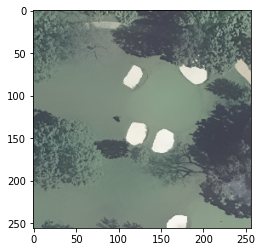

In [13]:
sharp = cv2.bilateralFilter(img, 60, 60, 60)
plt.imshow(sharp)

6. 1. Load a greyscale image

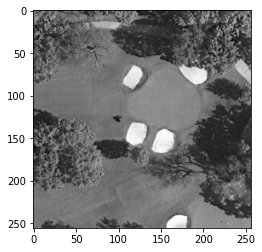

In [11]:
imgGray = color.rgb2gray(img)
imgGray_reshape= np.expand_dims(imgGray, axis=-1)
plt.imshow(imgGray, cmap='gray')

7. Generate some noisy versions by applying several noise models (with various
parameters)

In [12]:
#Function adds gaussian , salt-pepper , poisson and speckle noise in an image

#     One of the following strings, selecting the type of noise to add:

#     'gaussian'     Gaussian-distributed additive noise.
#     'poisson'   Poisson-distributed noise generated from the data.
#     'saltpepper'       Replaces random pixels with 0 or 1.
#     'speckle'   Multiplicative noise using out = image + n*image,where
#                 n is uniform noise with specified mean & variance.

def add_noise(noise_typ,image):
    #gaussian noise
    if noise_typ == "gaussian":
        row,col,ch= image.shape
        mean = 0
        var = 0.01
        sigma = var**0.5
        gaussian = np.random.normal(mean,sigma,(row,col,ch))
        gaussian = gaussian.reshape(row,col,ch)
        noisy = image + gaussian
        return noisy
    #saltpepper noise
    elif noise_typ == "saltpepper":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i , int(num_salt)) for i in image.shape]
        out[coords] = 1
        
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    #poisson noise
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 1.5** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    
    #speckle noise
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy


/tmp/ipykernel_6454/3289934190.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/tmp/ipykernel_6454/3289934190.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


Text(0.5, 1.0, 'speckle Noise added')

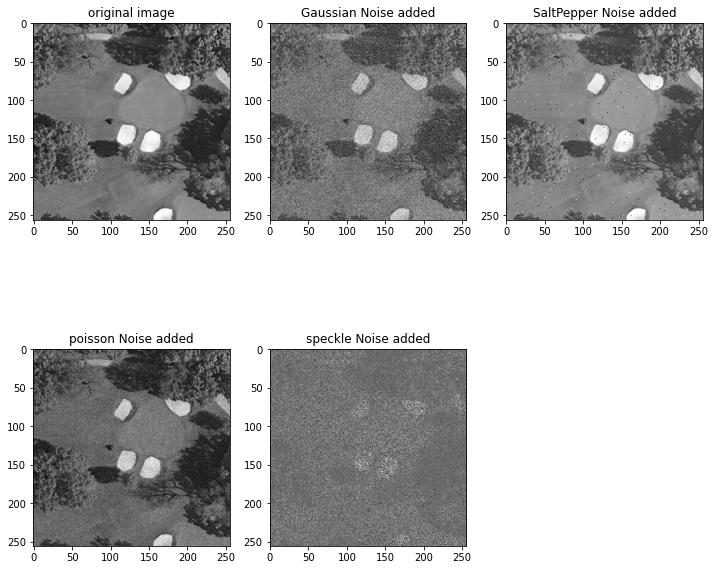

In [13]:
gaussian = add_noise('gaussian',imgGray_reshape)
sp = add_noise('saltpepper',imgGray_reshape)
poisson = add_noise('poisson',imgGray_reshape)
speckle = add_noise('speckle',imgGray_reshape)

plt.figure(figsize=(12,11))
plt.subplot(231)
plt.imshow(imgGray_reshape, cmap='gray')
plt.title('original image')
plt.subplot(232)
plt.imshow(gaussian, cmap='gray')
plt.title('Gaussian Noise added')
plt.subplot(233)
plt.imshow(sp, cmap='gray')
plt.title('SaltPepper Noise added')
plt.subplot(234)
plt.imshow(poisson, cmap='gray')
plt.title('poisson Noise added')
plt.subplot(235)
plt.imshow(speckle, cmap='gray')
plt.title('speckle Noise added')

8. Perform noise reduction/image restoration. 

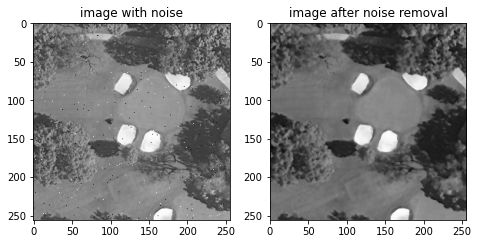

In [14]:
#using simple median filter on sp noise
sp_img = nd.median_filter(sp, size =3)
plt.figure(figsize = (12,10))
plt.subplot(131)
plt.imshow(sp, cmap='gray')
plt.title('image with noise')
plt.subplot(132)
plt.imshow(sp_img, cmap ='gray')
plt.title('image after noise removal')
plt.show()

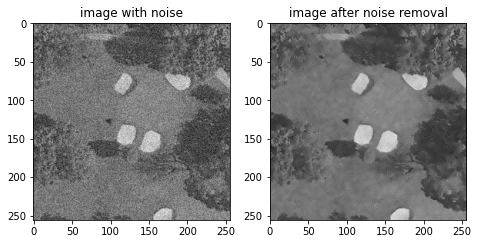

In [15]:
#another method on gaussian
from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(gaussian, multichannel = True))
denoise = denoise_nl_means(gaussian, h =1.15*sigma_est, fast_mode = False, patch_size = 5, patch_distance =3, multichannel = True)

#plot
plt.figure(figsize = (12,10))
plt.subplot(131)
plt.imshow(gaussian, cmap='gray')
plt.title('image with noise')
plt.subplot(132)
plt.imshow(denoise, cmap ='gray')
plt.title('image after noise removal')
plt.show()